In [ ]:
# Mount Drive...
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# For Testing...
!ls "/content/gdrive/My Drive/Anmol/Anmol_8_57_Stock/"  # remove this ...

'Predict Stock and Implied Volatility Data OOS 5.0 2021 results.csv'
'Predict Stock and Implied Volatility Data OOS 5.0.csv'


In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Read data...
dataset = pd.read_csv(f"/content/gdrive/My Drive/Anmol/Anmol_8_57_Stock/Predict Stock and Implied Volatility Data OOS 5.0 2021 results.csv")
dataset.head()

,Predict>,StockPriceIn10days,tradeDate,pxAtmIv,orFcst20d,orIvFcst20d,orFcstInf,orIvXern20d,orIvXernInf,volOfVol,...,fbfwd60_30.1,fbfwd90_60.1,fbfwd180_90.1,fbfwd90_30.1,fbfexErn30_20.1,fbfexErn60_30.1,fbfexErn90_60.1,fbfexErn180_90.1,fbfexErn90_30.1,impliedEarningsMove
0,NaN,0.0063,1/31/2007,143.75,10.1683,9.8551,12.22,9.63,13.26,0.0582,...,0.992056,1.01718,1.00792,1.00103,1.017280,1.02701,1.03060,1.01143,1.02713,2.82
1,NaN,0.0069,2/1/2007,144.61,10.1125,9.5683,12.25,9.78,13.37,0.0581,...,1.004600,1.02285,1.01253,1.01074,1.010130,1.02413,1.03344,1.01364,1.02607,2.66
2,NaN,0.0068,2/2/2007,144.81,9.5279,9.2018,11.95,9.27,13.22,0.0581,...,1.018850,1.02511,1.02322,1.02063,1.034060,1.03776,1.03269,1.02291,1.03527,2.43
3,NaN,0.0061,2/5/2007,144.85,9.2203,8.9397,12.07,10.10,13.19,0.0581,...,0.998004,1.02197,1.00980,1.00642,0.983009,1.01409,1.02823,1.01010,1.01865,2.65
4,NaN,0.0079,2/6/2007,144.89,9.6035,9.4875,11.78,9.22,13.74,0.0581,...,0.997221,1.02271,1.01185,1.00576,0.973504,1.01293,1.02914,1.01015,1.01734,2.50


In [ ]:
# Split the dataset into data & future_data...
# Convert the date column to datetime...
dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate'])

data = dataset[dataset['tradeDate'].dt.year == 2021]
# data = dataset[(dataset['tradeDate'].dt.year >= 2018) & (dataset['tradeDate'].dt.year <= 2021)]
test_data = dataset[dataset['tradeDate'].dt.year == 2022]
future_data = dataset[dataset['tradeDate'].dt.year >= 2023]

In [ ]:
# test_data_

# Top n Correlation with the target variable...
test_data_correlation_with_target = test_data.corrwith(test_data['StockPriceIn10days']).abs()

# Sorting and removing target variable's correlation...
test_data_correlation_with_target = test_data_correlation_with_target.sort_values(ascending=False).drop('StockPriceIn10days')

# Select the top n variables...
test_data_correlation_with_target_n = test_data_correlation_with_target.head(33).index

test_data_n_df = pd.DataFrame(test_data_correlation_with_target_n, columns=['Top n Variables'])
test_data_n_df.style.set_table_attributes("style='display:inline'")

<ipython-input-6-314e3d015439>:4: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data_correlation_with_target = test_data.corrwith(test_data['StockPriceIn10days']).abs()


,Top n Variables
0,Predict>
1,pxAtmIv
2,orFcst20d
3,orIvFcst20d
4,orFcstInf
5,orIvXern20d
6,orIvXernInf
7,volOfVol
8,volOfIvol
9,slope


In [ ]:
# data_

# Top n Correlation with the target variable...
data_correlation_with_target = data.corrwith(data['StockPriceIn10days']).abs()

# Sorting and removing target variable's correlation...
data_correlation_with_target = data_correlation_with_target.sort_values(ascending=False).drop('StockPriceIn10days')

# Select the top n variables...
data_correlation_with_target_n = data_correlation_with_target.head(33).index

data_n_df = pd.DataFrame(data_correlation_with_target_n, columns=['Top n Variables'])
data_n_df.style.set_table_attributes("style='display:inline'")

<ipython-input-7-7fbec066ca52>:4: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_correlation_with_target = data.corrwith(data['StockPriceIn10days']).abs()


,Top n Variables
0,ivEtfRatio.1
1,ivPctileEtf.1
2,fbfwd90_60
3,fbfexErn90_60
4,fbfwd90_30.1
5,contango
6,derivFcst
7,contango.1
8,fbfexErn60_30.1
9,fbfexErn90_30


In [ ]:
filtered_dataset = dataset[data_correlation_with_target_n.tolist() + ['tradeDate', 'StockPriceIn10days']]

# Split the filtered dataset into training and testing datasets...
train_filtered = filtered_dataset[filtered_dataset['tradeDate'].dt.year == 2021]
# train_filtered = filtered_dataset[(filtered_dataset['tradeDate'].dt.year >= 2018) & (filtered_dataset['tradeDate'].dt.year <= 2021)]
test_filtered = filtered_dataset[filtered_dataset['tradeDate'].dt.year == 2022]

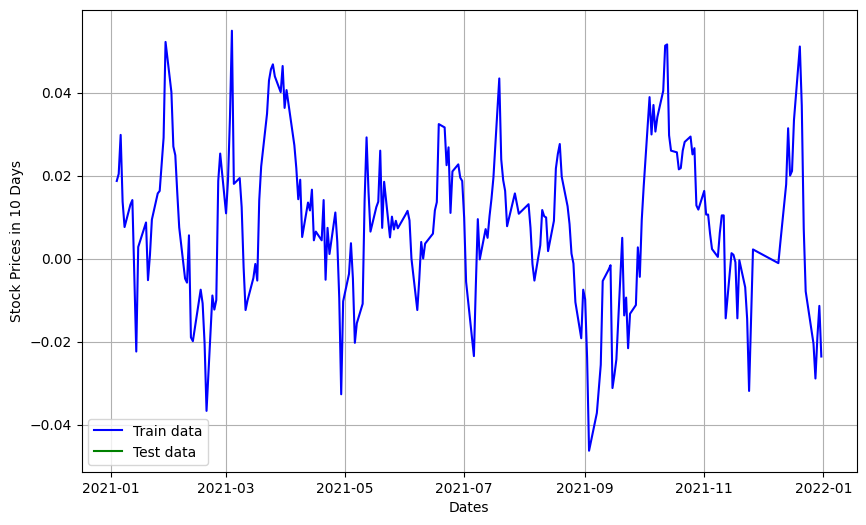

In [ ]:
target_column = 'StockPriceIn10days'

# Prepare data for plotting...
train_plot = train_filtered[['tradeDate', 'StockPriceIn10days']].set_index('tradeDate')
test_plot = test_filtered[['tradeDate', 'StockPriceIn10days']].set_index('tradeDate')

trade_Date = test_filtered['tradeDate']

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Stock Prices in 10 Days')
plt.plot(train_plot, 'b', label='Train data')
plt.plot(test_plot, 'g', label='Test data')
plt.legend()
plt.show()

In [ ]:
train_filtered = train_filtered.drop(['tradeDate'], axis=1)
train_filtered = train_filtered.apply(pd.to_numeric, errors='ignore')


test_filtered = test_filtered.drop(['tradeDate'], axis=1)
test_filtered = test_filtered.apply(pd.to_numeric, errors='ignore')


# Now split these into features and target
X_train = train_filtered.drop('StockPriceIn10days', axis=1)
y_train = train_filtered['StockPriceIn10days']
X_test = test_filtered.drop('StockPriceIn10days', axis=1)
y_test = test_filtered['StockPriceIn10days']

In [ ]:
# Normalizing the feature data...
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input to be [samples, time steps, features]...
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
# LSTM model architecture...
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=50))  # Adding more Dense layers...
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer...

model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model...

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Training the model...
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=50, shuffle=False, callbacks=[early_stop])  # Set epochs as needed

# Predicting and Evaluating...
y_pred = model.predict(X_test_reshaped)

Epoch 1/50
6/8 [=====================>........] - ETA: 0s - loss: 3.7249e-04 

8/8 [==============================] - 7s 12ms/step - loss: 3.5595e-04
Epoch 2/50
6/8 [=====================>........] - ETA: 0s - loss: 2.8850e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.7841e-04
Epoch 3/50
6/8 [=====================>........] - ETA: 0s - loss: 3.4738e-04

8/8 [==============================] - 0s 11ms/step - loss: 3.2991e-04
Epoch 4/50
6/8 [=====================>........] - ETA: 0s - loss: 2.7508e-04

8/8 [==============================] - 0s 11ms/step - loss: 2.7112e-04
Epoch 5/50
6/8 [=====================>........] - ETA: 0s - loss: 2.6192e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.5057e-04
Epoch 6/50
6/8 [=====================>........] - ETA: 0s - loss: 2.7564e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.6024e-04
Epoch 7/50
6/8 [=====================>........] - ETA: 0s - loss: 2.3623e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.3363e-04
Epoch 8/50
6/8 [=====================>........] - ETA: 0s - loss: 2.3381e-04

8/8 [==============================] - 0s 11ms/step - loss: 2.2817e-04
Epoch 9/50
6/8 [=====================>........] - ETA: 0s - loss: 2.3957e-04

8/8 [==============================] - 0s 11ms/step - loss: 2.3068e-04
Epoch 10/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2472e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.1600e-04
Epoch 11/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2514e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.2183e-04
Epoch 12/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2168e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.1344e-04
Epoch 13/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2601e-04

8/8 [==============================] - 0s 11ms/step - loss: 2.1873e-04
Epoch 14/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1095e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.1214e-04
Epoch 15/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1536e-04

8/8 [==============================] - 0s 14ms/step - loss: 2.0606e-04
Epoch 16/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2051e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.1133e-04
Epoch 17/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1234e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.0716e-04
Epoch 18/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1067e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.0328e-04
Epoch 19/50
6/8 [=====================>........] - ETA: 0s - loss: 2.0372e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.9628e-04
Epoch 20/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2306e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.1570e-04
Epoch 21/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1944e-04

8/8 [==============================] - 0s 11ms/step - loss: 2.1089e-04
Epoch 22/50
6/8 [=====================>........] - ETA: 0s - loss: 2.0862e-04

8/8 [==============================] - 0s 11ms/step - loss: 2.0250e-04
Epoch 23/50
6/8 [=====================>........] - ETA: 0s - loss: 1.8320e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.8333e-04
Epoch 24/50
6/8 [=====================>........] - ETA: 0s - loss: 2.2492e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.0897e-04
Epoch 25/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1500e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.0316e-04
Epoch 26/50
5/8 [=================>............] - ETA: 0s - loss: 1.7864e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.8746e-04
Epoch 27/50
5/8 [=================>............] - ETA: 0s - loss: 1.7866e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.9813e-04
Epoch 28/50
6/8 [=====================>........] - ETA: 0s - loss: 2.0092e-04

8/8 [==============================] - 0s 11ms/step - loss: 1.9097e-04
Epoch 29/50
6/8 [=====================>........] - ETA: 0s - loss: 1.8547e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.7965e-04
Epoch 30/50
6/8 [=====================>........] - ETA: 0s - loss: 1.8954e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.8063e-04
Epoch 31/50
6/8 [=====================>........] - ETA: 0s - loss: 1.8408e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.7831e-04
Epoch 32/50
6/8 [=====================>........] - ETA: 0s - loss: 1.8129e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.6978e-04
Epoch 33/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1570e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.9937e-04
Epoch 34/50
6/8 [=====================>........] - ETA: 0s - loss: 1.9399e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.8646e-04
Epoch 35/50
6/8 [=====================>........] - ETA: 0s - loss: 1.9518e-04

8/8 [==============================] - 0s 13ms/step - loss: 1.8159e-04
Epoch 36/50
6/8 [=====================>........] - ETA: 0s - loss: 1.9083e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.7633e-04
Epoch 37/50
6/8 [=====================>........] - ETA: 0s - loss: 2.0992e-04

8/8 [==============================] - 0s 11ms/step - loss: 1.9138e-04
Epoch 38/50
6/8 [=====================>........] - ETA: 0s - loss: 1.7269e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.7343e-04
Epoch 39/50
6/8 [=====================>........] - ETA: 0s - loss: 2.0227e-04

8/8 [==============================] - 0s 12ms/step - loss: 1.9344e-04
Epoch 40/50
6/8 [=====================>........] - ETA: 0s - loss: 2.1567e-04

8/8 [==============================] - 0s 12ms/step - loss: 2.0764e-04
Epoch 41/50
8/8 [==============================] - ETA: 0s - loss: 2.1317e-04

8/8 [==============================] - 0s 16ms/step - loss: 2.1317e-04
Epoch 42/50
7/8 [=========================>....] - ETA: 0s - loss: 1.8728e-04

8/8 [==============================] - 0s 19ms/step - loss: 1.8507e-04
Epoch 43/50
7/8 [=========================>....] - ETA: 0s - loss: 1.8019e-04

8/8 [==============================] - 0s 18ms/step - loss: 1.7819e-04
Epoch 44/50
7/8 [=========================>....] - ETA: 0s - loss: 1.6344e-04

8/8 [==============================] - 0s 20ms/step - loss: 1.6159e-04
Epoch 45/50
7/8 [=========================>....] - ETA: 0s - loss: 1.7383e-04

8/8 [==============================] - 0s 18ms/step - loss: 1.6986e-04
Epoch 46/50
7/8 [=========================>....] - ETA: 0s - loss: 1.7538e-04

8/8 [==============================] - 0s 18ms/step - loss: 1.7599e-04
Epoch 47/50
7/8 [=========================>....] - ETA: 0s - loss: 1.6595e-04

8/8 [==============================] - 0s 18ms/step - loss: 1.6412e-04
Epoch 48/50
7/8 [=========================>....] - ETA: 0s - loss: 1.5376e-04

8/8 [==============================] - 0s 18ms/step - loss: 1.5184e-04
Epoch 49/50
7/8 [=========================>....] - ETA: 0s - loss: 1.5225e-04

8/8 [==============================] - 0s 18ms/step - loss: 1.5075e-04
Epoch 50/50
7/8 [=========================>....] - ETA: 0s - loss: 1.4621e-04

8/8 [==============================] - 1s 5ms/step


In [ ]:
# # Calculating RMSE...
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Root Mean Squared Error: ', rmse)

In [ ]:
# float to 1 or 0 value...
def prediction(series):
    return series.apply(lambda x: +1 if x > 0 else 0)

In [ ]:
# y_test_s = prediction(y_test)

y_pred_s = prediction(pd.Series(y_pred.squeeze()))

In [ ]:
# y_test_s.value_counts()

In [ ]:
y_pred_s.value_counts()

1    236
0      1
dtype: int64

In [ ]:
# Save data...
y_pred_s.to_csv('prediction_data_2021.csv', header=True)

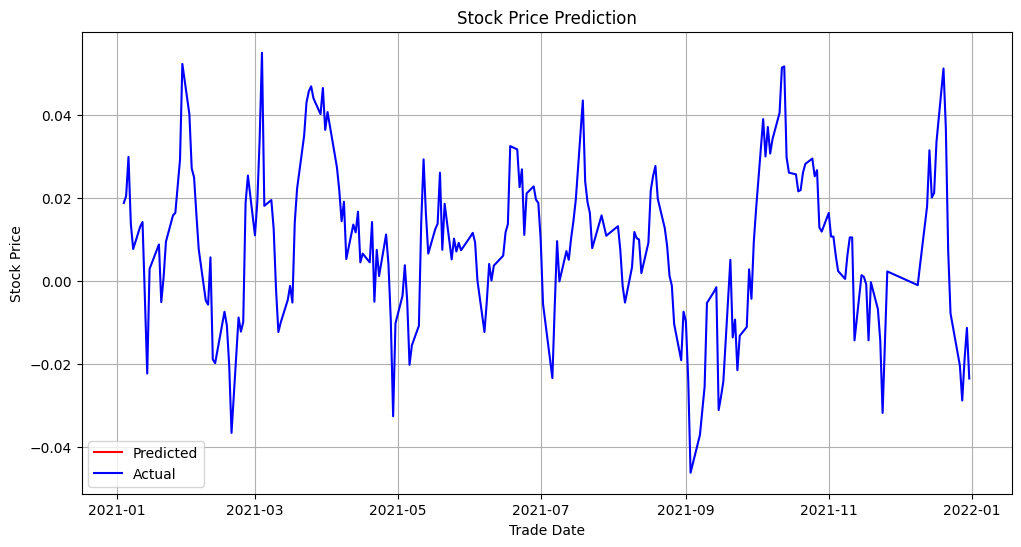

In [ ]:
plot_data = pd.DataFrame({
    'Trade Date': trade_Date,
    'Actual': y_test,
    'Predicted': y_pred_series
})

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Trade Date'], plot_data['Predicted'], label='Predicted', color='red')
plt.plot(plot_data['Trade Date'], plot_data['Actual'], label='Actual', color='blue')
plt.title('Stock Price Prediction')
plt.xlabel('Trade Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
score = accuracy_score(y_test_s, y_pred_s)
score

0.6848739495798319

In [ ]:
y_test_s_reset = y_test_s.reset_index(drop=True)
y_pred_s_reset = y_pred_s.reset_index(drop=True)

df_combined_reset = pd.DataFrame({'y_test_s': y_test_s_reset, 'y_pred_s': y_pred_s_reset})
styled_df = df_combined_reset.style.set_table_attributes("style='display:inline'")

# Display the styled DataFrame...
styled_df

,y_test_s,y_pred_s
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,0,1
8,0,1
9,1,1


In [ ]:
# On Future Data...
# future_data
# Top n Correlation with the target variable...
future_data_correlation_with_target = test_data.corrwith(future_data['StockPriceIn10days']).abs()

# Sorting and removing target variable's correlation...
future_data_correlation_with_target = future_data_correlation_with_target.sort_values(ascending=False).drop('StockPriceIn10days')

# Select the top n variables...
future_data_correlation_with_target_n = future_data_correlation_with_target.head(33).index

future_data_n_df = pd.DataFrame(future_data_correlation_with_target_n, columns=['Top n Variables'])
future_data_n_df.style.set_table_attributes("style='display:inline'")

<ipython-input-24-94ae630614c2>:4: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  future_data_correlation_with_target = test_data.corrwith(future_data['StockPriceIn10days']).abs()


,Top n Variables
0,Predict>
1,pxAtmIv
2,orFcst20d
3,orIvFcst20d
4,orFcstInf
5,orIvXern20d
6,orIvXernInf
7,volOfVol
8,volOfIvol
9,slope


In [ ]:
future_data_ = future_data[data_correlation_with_target_n].copy()

In [ ]:
future_data_scaled = scaler.transform(future_data_)

# Reshape the input to be [samples, time steps, features]...
future_data_reshaped = np.reshape(future_data_scaled, (future_data_scaled.shape[0], 1, future_data_scaled.shape[1]))

In [ ]:
# Predicting on Future Data...
future_data_pred = model.predict(future_data_reshaped)

8/8 [==============================] - 0s 5ms/step


In [ ]:
future_data_pred_seq = prediction(pd.Series(future_data_pred.squeeze()))

future_data_pred_seq.to_csv('future_data_pred_seq.csv', header=True)

In [ ]:
future_data_pred_seq.value_counts()

0    162
1     75
dtype: int64

In [ ]:
# Done...